In [1]:
import json
import os

from pdf2image import convert_from_path
from easydict import EasyDict as edict
from navertrans import navertrans
import matplotlib.pyplot as plt
from easyocr import Reader
from bardapi import Bard
import numpy as np
import cv2

![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54)
![OpenCV](https://img.shields.io/badge/opencv-%23white.svg?style=for-the-badge&logo=opencv&logoColor=white)
![NumPy](https://img.shields.io/badge/numpy-%23013243.svg?style=for-the-badge&logo=numpy&logoColor=white)
![Matplotlib](https://img.shields.io/badge/Matplotlib-%23ffffff.svg?style=for-the-badge&logo=Matplotlib&logoColor=black)
![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)
![BardAPI](https://img.shields.io/badge/pypi-BardAPI-black)

In [2]:
ROOT_PATH   = '/'.join(os.getcwd().split(os.path.sep)[:-6])
CONFIG_PATH = f'{ROOT_PATH}/utils/config.json'
CONFIG      = edict(json.loads(open(CONFIG_PATH, 'r').read()))

os.environ['_BARD_API_KEY'] = CONFIG.bard

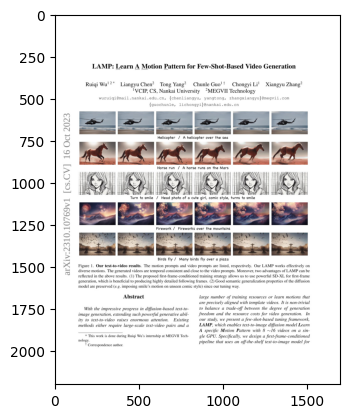

In [3]:
pages  = convert_from_path('LAMP.pdf', fmt = 'jpg')
reader = Reader(lang_list = ['en'], gpu = True) 
plt.imshow(pages[0])

In [12]:
## 페이지에 있는 figure나 table을 가려주는 함수 
## figure나 table에 글자가 있는 경우에 OCR이 읽어 문장이 이상해지는 경우가 있어 만듦.
def get_masked_page(image, need_rect = False):
    
    image    = np.array(image)
    image_cp = image.copy()
    
    gray     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, bin_  = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)
    
    H, W     = image.shape[:2]

    ## 페이지 내 글씨 이외의 figure나 table의 contour를 찾음.
    conts, _ = cv2.findContours(bin_, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    areas    = [cv2.contourArea(cont) for cont in conts]
    conts    = [(area, cont) for area, cont in zip(areas, conts) 
                    if 1000 < area < H * W - 5000]
    
    if len(conts) != 0:
        conts = sorted(conts, key = lambda x: x[0], reverse = True)
        for cont in conts:
            x, y, w, h = cv2.boundingRect(cont[1])
            cv2.rectangle(image_cp, (x, y), (x + w, y + h), (0, 255, 0), 15)

            figure     = gray[y: y + h, x - 10: x + (w + 10)]
            cv2.rectangle(gray, (x - 10, y), (x + (w + 10), y + h), (0, 0, 0), -1)
    
    if need_rect: 
        assert len(conts)!= 0, '해당 페이지에서는 figure 혹은 table을 찾을 수 없었습니다.'
        return gray, figure, image_cp
    
    return gray


## OCR을 이용하여 이미지에 있는 글자들을 읽어주는 함수
def read_text(image):
    
    results = reader.readtext(image)
    texts   = ' '.join([text[1] for text in results if len(text[1]) != 1])
    
    return texts


## Daniel Park 님께서 만들어주신 BardAPI를 통해 번역해주는 함수 
## https://github.com/dsdanielpark/Bard-API (GOAT)
def translate(prompt):
    
    prompt = f'다음 문장 한국어로 번역 해줘 {prompt}'  
    return Bard(timeout = 15).get_answer(prompt)


def naver_translate(prompt):

    return navertrans.translate(prompt, src_lan = 'en', tar_lan = 'ko')

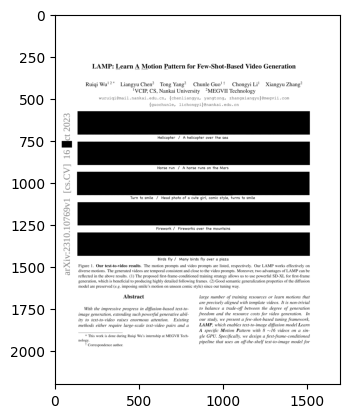

In [5]:
image, figure, rect = get_masked_page(pages[0], True)
plt.imshow(image, cmap = 'gray')

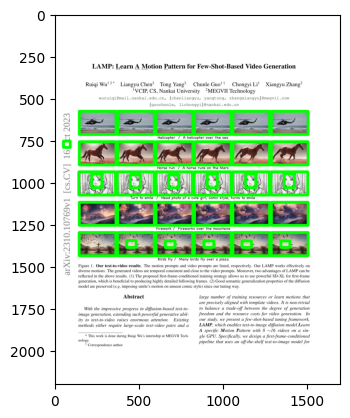

In [6]:
plt.imshow(rect)

In [13]:
text = read_text(image)
print(text)

translate = naver_translate(text)
translate

LAMP: Learn A Motion Pattern for Few-Shot-Based Video Generation Ruiqi Wul 2 Liangyu Chen? Yang? Chunle Guol Chongyi Lil Xiangyu Zhang? IVCIP; CS, Nankai University 2MEGVII Technology wuruiqi@mail nankai edu . cn, {chenliangyu, yangtong, zhangxiangyu}@megvii com {guochunle, li chongyi}@nankai edu . cn Helicopter A helicopter over the sea Horse run A horse runs on the Mars Turn to smile Head photo of cute girl, comic style, turns to smile Firework Fireworks Over the mountains Birds fly birds fly over plaza Figure 1. Our text-to-video results. The motion prompts and video prompts are listed, respectively: Our LAMP works effectively on diverse motions_ The generated videos are temporal consistent and close to the video prompts. Moreover; two advantages of LAMP can be reflected in the above results_ (1) The proposed first-frame-conditioned training strategy allows us to use powerful SD-XL for first-frame generation, which is beneficial to producing highly detailed following frames. (2) Goo

"램프: 퓨샷 기반 비디오 생성 Ruiqi Wul 2 Liangyu Chen을 위한 모션 패턴 학습? 양? 춘글궈총이 릴샹유장? IVCIP; CS, 난카이 대학 2MEGVII 기술 wuruiqi@mail nankai edu.cn, {chenliangyu, yangtong, zhangxiangyu}@megvii com {guochunle, lichongyi}@nankai edu.cn 헬리콥터 바다 위를 달리는 말 한 마리가 화성에서 달립니다. 웃는 얼굴로 돌아선 귀여운 소녀의 머리 사진, 코믹 스타일, 웃는 얼굴로 돌아선 산 위 불꽃놀이 새들이 플라자 그림 1 위를 날아갑니다. 텍스트와 비디오 간의 결과입니다. 동작 프롬프트와 비디오 프롬프트가 각각 나열되어 있습니다: 우리의 LAMP는 다양한 움직임에 효과적으로 작동한다_ 생성된 비디오는 시간적으로 일관되고 비디오 프롬프트에 가깝다.또한 LAMP의 두 가지 장점을 위의 결과에 반영할 수 있다. (1) 제안된 첫 번째 프레임 조건 훈련 전략을 통해 첫 번째 프레임 생성에 강력한 SD-XL을 사용할 수 있으며, 이는 매우 상세한 후속 프레임 생성에 유용하다.(2) 확산 모델의 좋은 의미론적 일반화 특성은 보이지 않는 코믹 스타일에 스마일'$ 모션을 부과하는 것으로 보존된다. 우리의 튜닝 방식: 템플릿 비디오와 정확하게 정렬된 훈련 리소스 또는 학습 모션의 수를 bstract한다: 생성 이미지 생성 정도 사이의 균형을 맞추기 위해 확산 기반 텍스트 대 텍스트의 인상적인 진전으로 이러한 강력한 생성 능력 자유도와 비디오 생성을 위한 자원 비용을 확장한다: 텍스트-투-비디오에 대한 정보는 엄청난 관심을 불러일으키는 것은 다음과 같습니다: 기존 연구; 우리는 몇 개의 샷 기반 프레임워크를 제시한다. 방법은 대규모 텍스트-비디오 쌍과 sin에서 8~16개의 비디오로 텍스트-이미지 확산 모델 학습 특정 모션 패턴을 가능하게 하는 LAMP를 필요로 한다. 이 작업은 MEGVII Tech-gle GPU에서 Ruiqi Wu의 인턴

In [14]:
image2 = get_masked_page(pages[1], 0)
text2  = read_text(image2)
print(text2)

translate2 = naver_translate(text2)
translate2

content generation SO that our tuned video diffusion model has semantic comprehension guided by the prompts, it mainly focuses on motion learning: The well-developed is reasonable that very little data is needed to make it under- text-to-image techniques can provide visually pleasing and stand the correspondence between prompts and motions and diverse content aS generation conditions, which highly im- generate diverse videos. Therefore, we attempt t0 explore proves video quality and generation freedom: To capture a novel few-shot for the TZV task The new the features of temporal dimension, we expand the pre - aims at tuning T2I diffusion model to Learn common trained 2D convolution layers of the TZI model to our novel Motion Pattern from small video set. temporal-spatial motion learning layers and modify the at- When T2I model to T2V model in a few-shot tention blocks to the temporal level. Additionally; we de- manner; two issues need to be addressed: (1) Due to the lim- velop an effec

'콘텐츠 생성 SO는 조정된 비디오 확산 모델이 프롬프트에 의해 안내되는 의미적 이해를 갖도록 하며, 주로 모션 학습에 초점을 맞춘다: 잘 개발된 것은 텍스트-투-이미지 기술 하에서 시각적으로 만족스럽고 다양한 동영상을 생성하는 프롬프트와 모션 및 다양한 콘텐츠 aS 생성 조건 사이의 대응을 견딜 수 있는 매우 적은 데이터가 필요하다는 것이 합리적이다.따라서 우리는 t0 탐색을 시도하여 비디오 품질과 세대의 자유를 증명합니다: TZV 작업을 위한 새로운 몇 개의 샷을 캡처하기 시간적 차원의 새로운 기능을 통해 T2I 확산 모델을 TZI 모델의 공통 훈련된 2D 컨볼루션 레이어를 작은 비디오 세트에서 새로운 모션 패턴으로 학습하는 사전 목표를 확장한다. 시간적-공간적 움직임 학습 레이어를 생성하고, 퓨샷 주의 블록에서 T2I 모델을 T2V 모델로 시간적 레벨로 수정한다.또한, 우리는 두 가지 문제를 해결할 필요가 있다. (1) 효과적인 추론 트릭 공유 노이즈 샘플링의 한계로 인해 데이터 양이 증가한다. 생성된 비디오가 국가 비용과 유사한 경우, 비디오 세트 내에서 계산으로 비디오의 안정성을 향상시킬 수 있는 콘텐츠를 과적합시킬 위험이 있다. 우리의 방법은 또한 비디오 세트에 유연하게 적용될 수 있다; 그것은 우리의 핵심 목표 중 하나, 즉 다른 작업들을 약화시킨다.실제 이미지 애니메이션 및 비디오 편집-생성 자유. (2) TZI 확산의 기본 연산자 광범위한 실험은 LAMP 모델이 제한된 데이터에 대한 모션 패턴을 효과적으로 학습하고 고품질 비디오를 먹는 비디오 내에서 시간 정보를 캡처하는 능력을 제한하는 공간 차원에서만 작동할 수 있음을 보여준다. 코드와 모델을 사용할 수 있다. 두 가지 어려운 문제를 가지고, 우리는 베이스-앳 https를 제안한다: Ilrg-wu:gubitio/projects/LAMP.LAMP로 명명된 퓨샷 TZV 생성을 위한 라인 방법. 첫 번째 이슈에 대한 우리의 해결책은 제안된 첫 번째 프레임 조건 파이프라인이다. TZV 작업을 두 개의